# Positional Spending Analysis
**Name:** Jaime Avendaño  
**Date:** 5/21/2021  
<br>
This notebook takes the positional spending data and does feature engineering by normalizing the spending. All values are compared to the NFL Salary Cap for the given year.  
<br>
The salary cap for each team can vary slightly, since there is an amount that can be rolled over. Also, these numbers don't count the dead money from old contracts or released players. But by comparing it to a single number for a year, we can get a relative percentage that can be compared across teams and years.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mtick
import seaborn as sns

import plotly.graph_objects as go
from plotly.colors import n_colors

import janitor

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [32]:
df = pd.read_parquet('teams_spending_df.parquet')
details_df = pd.read_parquet('teams_detail_df.parquet')
logos_df = pd.read_parquet('teams_logos_df.parquet')
df.shape, details_df.shape, logos_df.shape

((288, 15), (256, 5), (32, 4))

In [33]:
teams = df.team.unique().astype('str')
teams.sort()

In [34]:
positions = df.columns[1:-2]
positions

Index(['qb', 'rb', 'wr', 'te', 'ol', 'offense', 'idl', 'edge', 'lb', 's', 'cb',
       'defense'],
      dtype='object')

In [35]:
positions_pct = [f'{pos}_pct' for pos in positions if pos not in ['defense', 'offense']]
positions_pct

['qb_pct',
 'rb_pct',
 'wr_pct',
 'te_pct',
 'ol_pct',
 'idl_pct',
 'edge_pct',
 'lb_pct',
 's_pct',
 'cb_pct']

In [36]:
def getImage(path): 
    return OffsetImage(plt.imread(path), zoom=0.35)

## Feature Engineering
Preparing the totals and percentate of cap columns.

In [37]:
df['total'] = df['offense'] + df['defense']

In [38]:
for pos in positions:
    df[f'{pos}_pct'] = df[pos] / df.cap
df.head()

,team,qb,rb,wr,te,ol,offense,idl,edge,lb,...,wr_pct,te_pct,ol_pct,offense_pct,idl_pct,edge_pct,lb_pct,s_pct,cb_pct,defense_pct
0,Eagles,13385137,10203112,19241989,5509036,25664899,74004173,5264666,10241101,10004817,...,0.156439,0.044789,0.208658,0.601660,0.042802,0.083261,0.081340,0.056261,0.049047,0.312711
1,Seahawks,1557085,10799653,16831423,12778788,27955261,69922210,7701509,25013832,7377232,...,0.136841,0.103893,0.227279,0.568473,0.062614,0.203364,0.059977,0.069753,0.028519,0.424228
2,Titans,6336958,15376098,12686896,6979500,26721984,68101436,6496528,8776293,5740835,...,0.103145,0.056744,0.217252,0.553670,0.052817,0.071352,0.046673,0.087618,0.078069,0.336530
3,Broncos,18716295,5070632,10120554,8013902,24318758,66240141,6880138,5313554,12951882,...,0.082281,0.065154,0.197713,0.538538,0.055936,0.043200,0.105300,0.047922,0.142758,0.395115
4,Giants,21998400,5036739,8677626,2998913,24235900,62947578,5118995,9523813,7916847,...,0.070550,0.024381,0.197040,0.511769,0.041618,0.077429,0.064365,0.103293,0.091074,0.377778


In [39]:
@interact(team=widgets.Dropdown(options=teams, description='Select team: '))
def f(team):
    df_long = df.loc[df.team == team, ['team', 'year','offense_pct','defense_pct']]
    df_long = df_long.melt(id_vars=['team', 'year'], value_vars=['offense_pct', 'defense_pct'],
                           var_name='position', value_name='cap_pct')
    plt.figure(figsize=(15, 10))
    sns.lineplot(data=df_long, x='year', y='cap_pct', hue='position')
    return None;

C:\Users\jaime.avendano\Anaconda3\lib\site-packages\traitlets\traitlets.py:586: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Select team: ', options=('49ers', 'Bears', 'Bengals', 'Bills', 'Br…

In [40]:
def get_single_year_data(df, year):
    df_year = df[df.year == year][['team', 'offense_pct', 'defense_pct']]
    df_year = df_year.join(logos_df.set_index('team'), on='team')
    return df_year

In [41]:
@interact(plot_year=widgets.Dropdown(options=range(2013, 2021), description='Select year: '))
def f(plot_year):
    plot_df = get_single_year_data(df, plot_year)

    plt.figure(figsize=(12, 12))
    sns.set_style('darkgrid')
    ax = sns.scatterplot(data=df, x='offense_pct', y='defense_pct', s=4)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xlim((0.2, 0.6))
    plt.ylim((0.2, 0.6))


    for x0, y0, path in zip(plot_df.offense_pct, plot_df.defense_pct, plot_df.path):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
        ax.add_artist(ab)

    plt.suptitle(f'NFL - Cap Spending ({ plot_year } highlighted)', fontsize=20, y=0.93)
    plt.title('Does not include dead money for the year.', fontsize=15)
    plt.xlabel('% of Cap spent on Offense', fontsize=18)
    plt.ylabel('% of Cap spent on Defense', fontsize=18)
    plt.show()
    return None;

interactive(children=(Dropdown(description='Select year: ', options=(2013, 2014, 2015, 2016, 2017, 2018, 2019,…

In [42]:
team_avg_spending = df[['team', 'offense_pct', 'defense_pct']].groupby('team').mean().reset_index()
team_avg_spending.describe()

,offense_pct,defense_pct
count,32.000000,32.000000
mean,0.448416,0.418107
std,0.032713,0.035482
min,0.378094,0.343014
25%,0.434256,0.392952
50%,0.449247,0.427205
75%,0.468599,0.443904
max,0.508775,0.479979


In [43]:
team_avg_spending.sort_values('offense_pct').head()

,team,offense_pct,defense_pct
24,Ravens,0.378094,0.441465
3,Bills,0.388025,0.450515
12,Dolphins,0.390519,0.453997
16,Jaguars,0.402557,0.440993
4,Broncos,0.408136,0.478347


## KMeans Analysis

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score

In [45]:
positions_pct

['qb_pct',
 'rb_pct',
 'wr_pct',
 'te_pct',
 'ol_pct',
 'idl_pct',
 'edge_pct',
 'lb_pct',
 's_pct',
 'cb_pct']

In [46]:
#kmeans_data = df.join(details_df.set_index(['year', 'team']), on=['year', 'team'], how='inner')[positions_pct + ['win_pct']].copy()
#kmeans_data = df.join(details_df.set_index(['year', 'team']), on=['year', 'team'], how='inner')[['offense_pct', 'defense_pct']].copy()
kmeans_data = df.join(details_df.set_index(['year', 'team']), on=['year', 'team'], how='inner')[positions_pct].copy()
kmeans_data.head()

,qb_pct,rb_pct,wr_pct,te_pct,ol_pct,idl_pct,edge_pct,lb_pct,s_pct,cb_pct
0,0.108822,0.082952,0.156439,0.044789,0.208658,0.042802,0.083261,0.081340,0.056261,0.049047
1,0.012659,0.087802,0.136841,0.103893,0.227279,0.062614,0.203364,0.059977,0.069753,0.028519
2,0.051520,0.125009,0.103145,0.056744,0.217252,0.052817,0.071352,0.046673,0.087618,0.078069
3,0.152165,0.041225,0.082281,0.065154,0.197713,0.055936,0.043200,0.105300,0.047922,0.142758
4,0.178849,0.040949,0.070550,0.024381,0.197040,0.041618,0.077429,0.064365,0.103293,0.091074


In [47]:
kmeans_data['skill_pos_pct'] = kmeans_data['rb_pct'] + kmeans_data['wr_pct'] + kmeans_data['te_pct']
kmeans_data['def_front_pct'] = kmeans_data['idl_pct'] + kmeans_data['edge_pct'] + kmeans_data['lb_pct']
kmeans_data['def_backs_pct'] = kmeans_data['s_pct'] + kmeans_data['cb_pct']
kmeans_data = kmeans_data.drop(columns=['rb_pct', 'wr_pct', 'te_pct', 'idl_pct', 'edge_pct', 'lb_pct', 's_pct', 'cb_pct'])

In [48]:
kmeans_data.describe()

,qb_pct,ol_pct,skill_pos_pct,def_front_pct,def_backs_pct
count,256.000000,256.000000,256.000000,256.000000,256.000000
mean,0.094615,0.158892,0.184358,0.259330,0.149787
std,0.048310,0.041257,0.045228,0.059617,0.049788
min,0.007666,0.040623,0.076744,0.089453,0.050437
25%,0.053108,0.130671,0.156896,0.215515,0.111904
50%,0.095976,0.154496,0.184788,0.259532,0.151131
75%,0.133372,0.190164,0.212091,0.305886,0.182531
max,0.237667,0.281236,0.328535,0.404949,0.332771


In [49]:
kmeans_kwargs = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 100,
    'random_state': 42
}

In [50]:
km_scores= []
km_silhouette = []
db_score = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, **kmeans_kwargs)
    km.fit(kmeans_data)
    preds = km.predict(kmeans_data)
    
    km_scores.append(-km.score(kmeans_data))
    km_silhouette.append(silhouette_score(kmeans_data, preds))
    db_score.append(davies_bouldin_score(kmeans_data, preds))

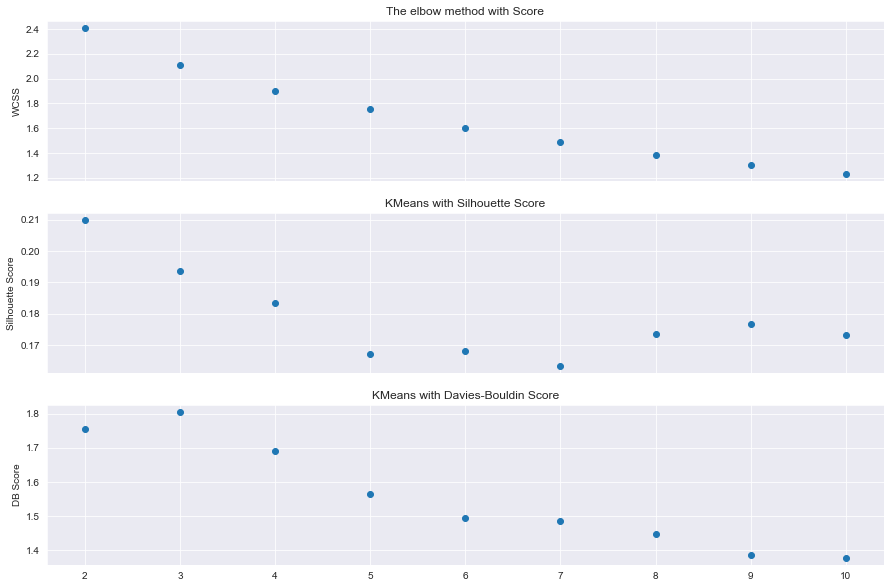

In [51]:
fig, axs = plt.subplots(3, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

axs[0].scatter(x=range(2, 11), y=km_scores)
axs[0].set_title('The elbow method with Score')
axs[0].set(ylabel='WCSS')

axs[1].scatter(x=range(2, 11), y=km_silhouette)
axs[1].set_title('KMeans with Silhouette Score')
axs[1].set(ylabel='Silhouette Score')

axs[2].scatter(x=range(2, 11), y=db_score)
axs[2].set_title('KMeans with Davies-Bouldin Score')
axs[2].set(ylabel='DB Score')

plt.show();

In [52]:
km = KMeans(n_clusters=6, **kmeans_kwargs)
nfl_pred = km.fit_predict(kmeans_data)

In [53]:
df_grouped = df[df.year <= 2020].copy()
df_grouped['group'] = nfl_pred

In [54]:
df_grouped['teams'] = df_grouped[df_grouped.year == 2019][['group', 'team']].reset_index().groupby(['group'])['team'].transform(lambda x: ', '.join(x))
group_2019_df = df_grouped[df_grouped.year == 2019][['group', 'teams']].drop_duplicates()
group_2019_df


,group,teams
0,2,"Packers, Chargers, Giants"
1,4,"Buccaneers, Rams, Bills"
3,0,"Washington, Raiders, Titans, Lions, Patriots, ..."
4,1,"Bengals, Browns, Cowboys, Colts, Chiefs, Eagle..."
7,5,"49ers, Saints, Falcons, Seahawks, Steelers, Pa..."
13,3,"Vikings, Texans, Bears"


In [55]:
km_centers_df = pd.DataFrame(km.cluster_centers_, columns=['qb_pct', 'ol_pct', 'skill_pos_pct', 'def_front_pct', 'def_backs_pct'])
km_centers_df

,qb_pct,ol_pct,skill_pos_pct,def_front_pct,def_backs_pct
0,0.119513,0.150984,0.158227,0.186586,0.196191
1,0.044367,0.191741,0.201702,0.232452,0.155091
2,0.135194,0.161479,0.200706,0.222426,0.116409
3,0.071422,0.130103,0.189287,0.301982,0.183293
4,0.068724,0.165448,0.217353,0.326246,0.097044
5,0.119417,0.172083,0.127278,0.299409,0.134926


In [88]:
km_table = km_centers_df.join(group_2019_df.set_index('group'))
km_table['qb_rank'] = km_table.qb_pct.rank(method='first', ascending=True).astype('int') - 1
km_table['ol_rank'] = km_table.ol_pct.rank(method='first', ascending=True).astype('int') - 1
km_table['skill_pos_rank'] = km_table.skill_pos_pct.rank(method='first', ascending=True).astype('int') - 1
km_table['def_front_rank'] = km_table.def_front_pct.rank(method='first', ascending=True).astype('int') - 1
km_table['def_backs_rank'] = km_table.def_backs_pct.rank(method='first', ascending=True).astype('int') - 1
km_table

,qb_pct,ol_pct,skill_pos_pct,def_front_pct,def_backs_pct,teams,qb_rank,ol_rank,skill_pos_rank,def_front_rank,def_backs_rank
0,0.119513,0.150984,0.158227,0.186586,0.196191,"Washington, Raiders, Titans, Lions, Patriots, ...",4,1,1,0,5
1,0.044367,0.191741,0.201702,0.232452,0.155091,"Bengals, Browns, Cowboys, Colts, Chiefs, Eagle...",0,5,4,2,3
2,0.135194,0.161479,0.200706,0.222426,0.116409,"Packers, Chargers, Giants",5,2,3,1,1
3,0.071422,0.130103,0.189287,0.301982,0.183293,"Vikings, Texans, Bears",2,0,2,4,4
4,0.068724,0.165448,0.217353,0.326246,0.097044,"Buccaneers, Rams, Bills",1,3,5,5,0
5,0.119417,0.172083,0.127278,0.299409,0.134926,"49ers, Saints, Falcons, Seahawks, Steelers, Pa...",3,4,0,3,2


In [158]:
colors = np.array(n_colors('rgb(225, 225, 255)', 'rgb(125, 125, 255)', 6, colortype='rgb'))

fig = go.Figure(data=[go.Table(
  header=dict(
      values=['<b>Cluster</b>', '<b>Teams</b>', '<b>QB %</b>', '<b>OL %</b>', '<b>Skill Pos %</b>', '<b>Def Front %</b>', '<b>Def Backs %</b>'],
      align=['left', 'left', 'center'],
      font=dict(color='black', size=15),
      fill_color='white',
      line_color='black'
  ),
  columnwidth=[5,30,10,10,10,10,10],
  cells=dict(
      values=[km_table.index.tolist(), km_table.teams, km_table.qb_pct, km_table.ol_pct, km_table.skill_pos_pct, km_table.def_front_pct, km_table.def_backs_pct],
      format=[None, None, '.3p'],
      line_color='black',
      fill_color=[colors[km_table.index.tolist()], 
                  colors[km_table.index.tolist()], 
                  colors[km_table.qb_rank], 
                  colors[km_table.ol_rank], 
                  colors[km_table.skill_pos_rank], 
                  colors[km_table.def_front_rank], 
                  colors[km_table.def_backs_rank]],
      align=['left', 'left', 'center'],
      font=dict(color='black', size=13)
    )),
])
fig.update_layout(title=dict(text='NFL Cap Spending for 2019', y=0.95),
                 margin=dict(l=20, r=20, t=55, b=20),
                 height=250)

fig.show()